In [ ]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 576.1 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#1.1 Coleta de Notícias

Nesta etapa reunimos o corpus de notícias que alimenta a componente textual do estudo. O notebook assume que as notícias já foram coletadas por scraping/APIs e armazenadas em formato tabular (data, título, texto, fonte). O propósito aqui é preservar a granularidade temporal (data de publicação) e metadados necessários para posterior alinhamento com os pregões.


In [ ]:
import os
import re
import json
import pandas as pd
import requests
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import urlparse

API_URL  = "https://api.github.com/repos/Matheus-B-Ferrari/AnaliseDeSentimentosB3/contents/noticias"
RAW_BASE = "https://raw.githubusercontent.com/Matheus-B-Ferrari/AnaliseDeSentimentosB3/main/noticias/"
RESULT_CSV = "sentimentos_resultado.csv"

# Carrega resultados já existentes
if os.path.exists(RESULT_CSV):
    df_resultado = pd.read_csv(RESULT_CSV)
    arquivos_processados = set(df_resultado["arquivo"].unique())
else:
    df_resultado = pd.DataFrame()
    arquivos_processados = set()

# Baixa lista de arquivos no repositório
res = requests.get(API_URL)
res.raise_for_status()
itens = res.json()

# Filtra apenas os .csv e monta um dicionário nome → download_url
download_map = {
    item["name"]: item["download_url"]
    for item in itens
    if item["name"].endswith(".csv")
}

arquivos_novos = [f for f in sorted(download_map) if f not in arquivos_processados]
print(f"Total de arquivos a analisar: {len(arquivos_novos)}")

def _read_csv_from_url(url):
    """
    Tenta ler um CSV a partir de uma URL raw com várias heurísticas de separador/encoding.
    Retorna DataFrame ou None em caso de falha.
    """
    text = None
    try:
        r = requests.get(url, timeout=20)
        r.raise_for_status()
        # tenta texto diretamente (raw)
        text = r.content
    except Exception as e:
        # falha de rede/timeout
        print(f"Erro ao baixar {url}: {e}")
        return None

    # tenta vários encodings/separadores
    attempts = [
        {"encoding": "utf-8",   "sep": None},
        {"encoding": "utf-8",   "sep": ","},
        {"encoding": "utf-8",   "sep": ";"},
        {"encoding": "latin1",  "sep": None},
        {"encoding": "latin1",  "sep": ","},
        {"encoding": "latin1",  "sep": ";"}
    ]

    for att in attempts:
        try:
            # se sep=None + engine='python' tentará detectar
            df = pd.read_csv(
                pd.io.common.BytesIO(text),
                sep=att["sep"],
                engine='python',
                encoding=att["encoding"]
            )
            return df
        except Exception:
            continue

    # última tentativa: carregar como texto e forçar splitlines -> csv
    try:
        s = text.decode('utf-8', errors='ignore')
        from io import StringIO
        df = pd.read_csv(StringIO(s), sep=None, engine='python')
        return df
    except Exception:
        return None

contagens = []
total_noticias = 0

for nome in tqdm(arquivos_novos, desc="Contando notícias por arquivo"):
    url = download_map[nome] if download_map.get(nome) else RAW_BASE + nome
    df = _read_csv_from_url(url)
    if df is None:
        print(f"Não foi possível ler: {nome} (pulando)")
        contagens.append({"arquivo": nome, "n_linhas": None, "obs": "read_failed"})
        continue

    # Normaliza colunas: remove BOM e espaços no cabeçalho
    df.columns = [c.strip().replace('\ufeff', '') for c in df.columns.astype(str)]

    # Se houver coluna 'titulo' ou 'texto' prefira contar linhas não-nulas,
    # caso contrário conte todas as linhas do csv (exceto cabeçalho)
    if 'titulo' in df.columns or 'texto' in df.columns:
        # conta linhas onde pelo menos um dos campos texto/título não é NaN/vazio
        cond = pd.Series(False, index=df.index)
        if 'titulo' in df.columns:
            cond = cond | df['titulo'].notna() & (df['titulo'].astype(str).str.strip() != "")
        if 'texto' in df.columns:
            cond = cond | df['texto'].notna() & (df['texto'].astype(str).str.strip() != "")
        n = int(cond.sum())
    else:
        # fallback: conta todas as linhas
        n = len(df)

    contagens.append({"arquivo": nome, "n_linhas": int(n), "obs": ""})
    total_noticias += int(n)

# monta DataFrame resumo e imprime
df_contagem = pd.DataFrame(contagens)
df_contagem = df_contagem.sort_values("arquivo").reset_index(drop=True)

print("\nContagem por arquivo (exemplo):")
print(df_contagem.to_string(index=False))

print(f"\n→ Total estimado de notícias nos arquivos novos: {total_noticias}")

# salva resumo opcional
resumo_path = "contagem_noticias_por_arquivo.csv"
df_contagem.to_csv(resumo_path, index=False)
print(f"\nResumo salvo em: {resumo_path}")


Total de arquivos a analisar: 123


Contando notícias por arquivo: 100%|██████████| 123/123 [00:11<00:00, 10.34it/s]


Contagem por arquivo (exemplo):
                arquivo  n_linhas obs
noticias_2025-05-01.csv        81    
noticias_2025-05-02.csv        82    
noticias_2025-05-03.csv        65    
noticias_2025-05-04.csv        54    
noticias_2025-05-05.csv        76    
noticias_2025-05-06.csv        80    
noticias_2025-05-07.csv        75    
noticias_2025-05-08.csv        69    
noticias_2025-05-09.csv        83    
noticias_2025-05-10.csv        54    
noticias_2025-05-11.csv        58    
noticias_2025-05-12.csv        79    
noticias_2025-05-13.csv        74    
noticias_2025-05-14.csv        80    
noticias_2025-05-15.csv        84    
noticias_2025-05-16.csv        75    
noticias_2025-05-17.csv        57    
noticias_2025-05-18.csv        56    
noticias_2025-05-19.csv        75    
noticias_2025-05-20.csv        73    
noticias_2025-05-21.csv        40    
noticias_2025-05-22.csv        78    
noticias_2025-05-23.csv        39    
noticias_2025-05-24.csv        55    
noticias_2025-05-

Carregando notícias para gráfico: 100%|██████████| 123/123 [00:07<00:00, 16.67it/s]


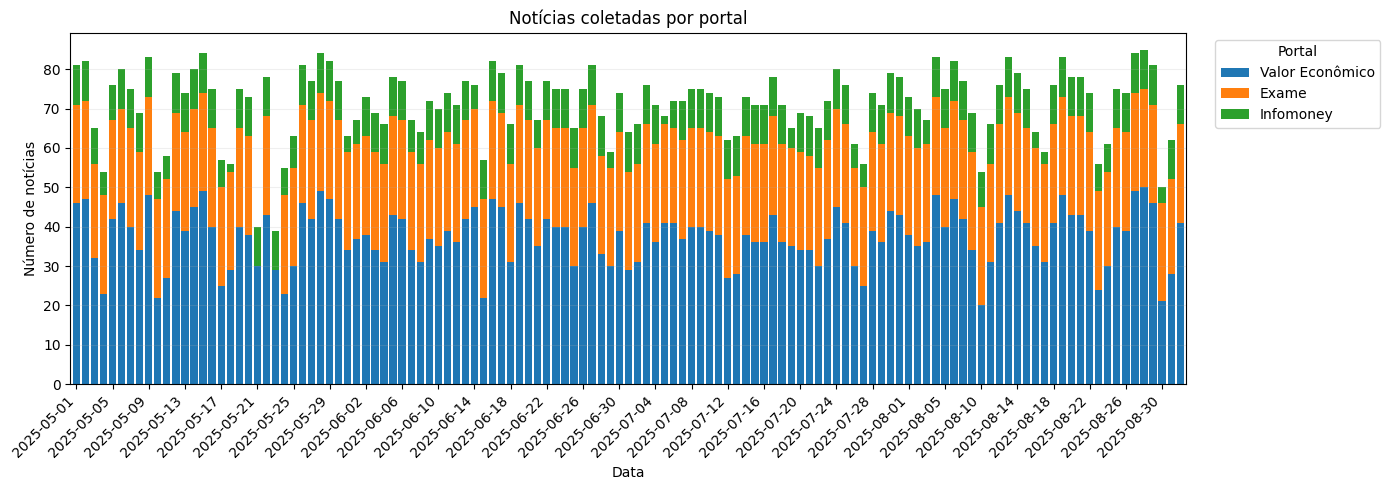

In [ ]:
lista_noticias = []

for nome in tqdm(arquivos_novos, desc="Carregando notícias para gráfico"):
    url = download_map.get(nome, RAW_BASE + nome)
    df = _read_csv_from_url(url)

    if df is None:
        continue

    # Normaliza colunas
    df.columns = [c.strip().replace('\ufeff', '') for c in df.columns.astype(str)]
    lista_noticias.append(df)

# Concatena tudo
if lista_noticias:
    df_noticias = pd.concat(lista_noticias, ignore_index=True)

    # Converte coluna 'data' para datetime
    if 'data' in df_noticias.columns:
        df_noticias['data'] = pd.to_datetime(df_noticias['data'], errors='coerce')
        df_noticias = df_noticias.dropna(subset=['data'])
        df_noticias['data'] = df_noticias['data'].dt.date

pivot = df_noticias.groupby(["data", "fonte"]).size().unstack(fill_value=0)
ordem_desejada = ['Valor Econômico', 'Exame', 'Infomoney']
colunas_existentes = [col for col in ordem_desejada if col in pivot.columns]
pivot = pivot[colunas_existentes]
cores = ['#1f77b4', '#ff7f0e', '#2ca02c']

fig, ax = plt.subplots(figsize=(14,5))
pivot.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=cores[:len(colunas_existentes)])

ax.set_xlabel('Data')
ax.set_ylabel('Número de notícias')
ax.set_title('Notícias coletadas por portal')
ax.legend(title='Portal', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.2)

n_dates = pivot.shape[0]
if n_dates > 30:
    step = max(1, n_dates // 30)
    positions = np.arange(n_dates)[::step]
    ax.set_xticks(positions)
    ax.set_xticklabels([str(d) for d in pivot.index.astype(str)][::step], rotation=45, ha='right')
else:
    ax.set_xticks(np.arange(n_dates))
    ax.set_xticklabels([str(d) for d in pivot.index.astype(str)], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('noticias_por_dia_empilhado.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

#1.2 Coleta de Preços dos Ativos

Aqui são obtidas/validadas as séries históricas de preços (open, high, low, close, volume). No código usamos a série de fechamento (`Close`) como target principal; os dados são convertidos para índice datetime, ordenados cronologicamente e verificados quanto a dias sem negociação. Esse passo prepara os dados para sincronização com a agregação diária de sentimento e para a construção das janelas temporais usadas pelo LSTM.


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime

tickers = ["PETR4.SA", "VALE3.SA", "EMBR3.SA", "BOVA11.SA"]

start_date = "2025-05-01"
end_date   = "2025-09-01"
precos = {}

for tk in tickers:
    print(f"Baixando dados de {tk} de {start_date} a {end_date}...")
    df = yf.download(tk, start=start_date, end=end_date, progress=False)[["Open","High","Low","Close","Volume"]]
    df.index.name = "date"
    df.columns = ["open","high","low","close","volume"]
    df = df.reset_index()

    # Armazena e salva CSV individual
    precos[tk] = df
    df.to_csv(f"data_{tk.replace('.','_')}_raw.csv", index=False)
    print(f"✔ Dados salvos: data_{tk.replace('.','_')}_raw.csv ({len(df)} linhas)")

print("\n Coleta concluída para todos os ativos.")


Baixando dados de PETR4.SA de 2025-05-01 a 2025-09-01...


/tmp/ipython-input-3704271095.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tk, start=start_date, end=end_date, progress=False)[["Open","High","Low","Close","Volume"]]


✔ Dados salvos: data_PETR4_SA_raw.csv (85 linhas)
Baixando dados de VALE3.SA de 2025-05-01 a 2025-09-01...


/tmp/ipython-input-3704271095.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tk, start=start_date, end=end_date, progress=False)[["Open","High","Low","Close","Volume"]]


✔ Dados salvos: data_VALE3_SA_raw.csv (85 linhas)
Baixando dados de EMBR3.SA de 2025-05-01 a 2025-09-01...


/tmp/ipython-input-3704271095.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tk, start=start_date, end=end_date, progress=False)[["Open","High","Low","Close","Volume"]]


✔ Dados salvos: data_EMBR3_SA_raw.csv (85 linhas)
Baixando dados de BOVA11.SA de 2025-05-01 a 2025-09-01...
✔ Dados salvos: data_BOVA11_SA_raw.csv (85 linhas)

 Coleta concluída para todos os ativos.


/tmp/ipython-input-3704271095.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tk, start=start_date, end=end_date, progress=False)[["Open","High","Low","Close","Volume"]]


#2.1 Modelo, Limpeza e Análise de Sentimento

Nesta etapa foi aplicado o pipeline de NLP (pré-processamento e inferência), os textos são normalizados, tokenizados e avaliados por FinBERT-PT-BR para gerar probabilidades de sentimento. O resultado é um score contínuo por notícia (ou probabilidades pos/neg/neu) que representa a tonalidade do conteúdo.

In [ ]:
import os
import re
import torch
import pandas as pd
from tqdm import tqdm
import spacy

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cache_dir = "./model_cache"

MODEL_NAME = "lucas-leme/FinBERT-PT-BR"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=cache_dir)
model      = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, cache_dir=cache_dir).to(device)
pipe       = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type=="cuda" else -1,
    truncation=True,
    batch_size=32
)

import spacy
nlp = spacy.load("pt_core_news_lg", disable=["ner", "parser"])  # mais leve

def limpar_com_spacy(texto):
    """
    Limpeza leve recomendada para uso com modelos Transformers (ex: FinBERT-PT-BR).
    Remove URLs e caracteres especiais básicos, mas mantém stopwords, pontuação leve e estrutura do texto.
    """
    texto = "" if texto is None else str(texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s.,!?;:()-]", " ", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto.lower()

def processar_arquivo(nome):
    url = download_map[nome]
    df_local = pd.read_csv(url)

    df_local["texto"] = df_local["texto"] if "texto" in df_local.columns else ""
    df_local["titulo"] = df_local["titulo"] if "titulo" in df_local.columns else ""
    df_local["data"] = df_local["data"] if "data" in df_local.columns else ""
    df_local["texto_limpo"] = df_local["texto"].apply(limpar_com_spacy).str[:256]

    resultados = pipe(df_local["texto_limpo"].tolist())
    df_local["sentimento"] = [r["label"] for r in resultados]
    df_local["score"]      = [r["score"] for r in resultados]

    df_local["arquivo"] = nome
    cols = ["arquivo", "data", "titulo", "texto", "sentimento", "score"]
    cols = [c for c in cols if c in df_local.columns]
    return df_local[cols]

if len(arquivos_novos) == 0:
    print("Nenhum arquivo novo para processar. Carregando", RESULT_CSV, "se existir.")
else:
    for nome in tqdm(arquivos_novos, desc="Processando arquivos"):
        print(f"\n Processando: {nome}")
        try:
            df_parcial = processar_arquivo(nome)
            df_parcial.to_csv(RESULT_CSV, mode='a', index=False, header=not os.path.exists(RESULT_CSV))
        except Exception as e:
            print(f"Erro em {nome}: {e}")

print("Análise concluída! Carregando resultado consolidado...")
df = pd.read_csv(RESULT_CSV)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Device set to use cpu
Processando arquivos:   0%|          | 0/123 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 Processando: noticias_2025-05-01.csv


Processando arquivos:   1%|          | 1/123 [00:21<43:51, 21.57s/it]


 Processando: noticias_2025-05-02.csv


Processando arquivos:   2%|▏         | 2/123 [00:43<43:45, 21.70s/it]


 Processando: noticias_2025-05-03.csv


Processando arquivos:   2%|▏         | 3/123 [01:00<39:17, 19.65s/it]


 Processando: noticias_2025-05-04.csv


Processando arquivos:   3%|▎         | 4/123 [01:14<34:46, 17.53s/it]


 Processando: noticias_2025-05-05.csv


Processando arquivos:   4%|▍         | 5/123 [01:38<38:30, 19.58s/it]


 Processando: noticias_2025-05-06.csv


Processando arquivos:   5%|▍         | 6/123 [02:02<41:38, 21.35s/it]


 Processando: noticias_2025-05-07.csv


Processando arquivos:   6%|▌         | 7/123 [02:25<41:50, 21.64s/it]


 Processando: noticias_2025-05-08.csv


Processando arquivos:   7%|▋         | 8/123 [02:42<38:45, 20.22s/it]


 Processando: noticias_2025-05-09.csv


Processando arquivos:   7%|▋         | 9/123 [03:04<39:47, 20.95s/it]


 Processando: noticias_2025-05-10.csv


Processando arquivos:   8%|▊         | 10/123 [03:18<35:01, 18.60s/it]


 Processando: noticias_2025-05-11.csv


Processando arquivos:   9%|▉         | 11/123 [03:33<32:44, 17.54s/it]


 Processando: noticias_2025-05-12.csv


Processando arquivos:  10%|▉         | 12/123 [03:55<34:50, 18.84s/it]


 Processando: noticias_2025-05-13.csv


Processando arquivos:  11%|█         | 13/123 [04:14<35:02, 19.12s/it]


 Processando: noticias_2025-05-14.csv


Processando arquivos:  11%|█▏        | 14/123 [04:35<35:40, 19.63s/it]


 Processando: noticias_2025-05-15.csv


Processando arquivos:  12%|█▏        | 15/123 [04:57<36:24, 20.22s/it]


 Processando: noticias_2025-05-16.csv


Processando arquivos:  13%|█▎        | 16/123 [05:17<36:09, 20.27s/it]


 Processando: noticias_2025-05-17.csv


Processando arquivos:  14%|█▍        | 17/123 [05:31<32:26, 18.36s/it]


 Processando: noticias_2025-05-18.csv


Processando arquivos:  15%|█▍        | 18/123 [05:48<31:21, 17.92s/it]


 Processando: noticias_2025-05-19.csv


Processando arquivos:  15%|█▌        | 19/123 [06:07<31:50, 18.37s/it]


 Processando: noticias_2025-05-20.csv


Processando arquivos:  16%|█▋        | 20/123 [06:26<31:48, 18.53s/it]


 Processando: noticias_2025-05-21.csv


Processando arquivos:  17%|█▋        | 21/123 [06:37<27:22, 16.10s/it]


 Processando: noticias_2025-05-22.csv


Processando arquivos:  18%|█▊        | 22/123 [06:59<30:02, 17.85s/it]


 Processando: noticias_2025-05-23.csv


Processando arquivos:  19%|█▊        | 23/123 [07:08<25:17, 15.17s/it]


 Processando: noticias_2025-05-24.csv


Processando arquivos:  20%|█▉        | 24/123 [07:21<24:24, 14.79s/it]


 Processando: noticias_2025-05-25.csv


Processando arquivos:  20%|██        | 25/123 [07:37<24:24, 14.95s/it]


 Processando: noticias_2025-05-26.csv


Processando arquivos:  21%|██        | 26/123 [07:56<26:17, 16.26s/it]


 Processando: noticias_2025-05-27.csv


Processando arquivos:  22%|██▏       | 27/123 [08:15<27:19, 17.08s/it]


 Processando: noticias_2025-05-28.csv


Processando arquivos:  23%|██▎       | 28/123 [08:37<29:17, 18.50s/it]


 Processando: noticias_2025-05-29.csv


Processando arquivos:  24%|██▎       | 29/123 [08:59<30:26, 19.43s/it]


 Processando: noticias_2025-05-30.csv


Processando arquivos:  24%|██▍       | 30/123 [09:19<30:43, 19.83s/it]


 Processando: noticias_2025-05-31.csv


Processando arquivos:  25%|██▌       | 31/123 [09:37<29:12, 19.05s/it]


 Processando: noticias_2025-06-01.csv


Processando arquivos:  26%|██▌       | 32/123 [09:52<27:21, 18.04s/it]


 Processando: noticias_2025-06-02.csv


Processando arquivos:  27%|██▋       | 33/123 [10:10<27:06, 18.07s/it]


 Processando: noticias_2025-06-03.csv


Processando arquivos:  28%|██▊       | 34/123 [10:27<26:19, 17.75s/it]


 Processando: noticias_2025-06-04.csv


Processando arquivos:  28%|██▊       | 35/123 [10:43<25:05, 17.10s/it]


 Processando: noticias_2025-06-05.csv


Processando arquivos:  29%|██▉       | 36/123 [11:05<27:05, 18.68s/it]


 Processando: noticias_2025-06-06.csv


Processando arquivos:  30%|███       | 37/123 [11:24<26:49, 18.71s/it]


 Processando: noticias_2025-06-07.csv


Processando arquivos:  31%|███       | 38/123 [11:40<25:29, 17.99s/it]


 Processando: noticias_2025-06-08.csv


Processando arquivos:  32%|███▏      | 39/123 [11:57<24:24, 17.44s/it]


 Processando: noticias_2025-06-09.csv


Processando arquivos:  33%|███▎      | 40/123 [12:15<24:35, 17.78s/it]


 Processando: noticias_2025-06-10.csv


Processando arquivos:  33%|███▎      | 41/123 [12:34<24:40, 18.06s/it]


 Processando: noticias_2025-06-11.csv


Processando arquivos:  34%|███▍      | 42/123 [12:53<24:49, 18.38s/it]


 Processando: noticias_2025-06-12.csv


Processando arquivos:  35%|███▍      | 43/123 [13:10<23:56, 17.95s/it]


 Processando: noticias_2025-06-13.csv


Processando arquivos:  36%|███▌      | 44/123 [13:31<24:52, 18.89s/it]


 Processando: noticias_2025-06-14.csv


Processando arquivos:  37%|███▋      | 45/123 [13:49<24:05, 18.53s/it]


 Processando: noticias_2025-06-15.csv


Processando arquivos:  37%|███▋      | 46/123 [14:04<22:42, 17.70s/it]


 Processando: noticias_2025-06-16.csv


Processando arquivos:  38%|███▊      | 47/123 [14:25<23:28, 18.53s/it]


 Processando: noticias_2025-06-17.csv


Processando arquivos:  39%|███▉      | 48/123 [14:46<24:02, 19.23s/it]


 Processando: noticias_2025-06-18.csv


Processando arquivos:  40%|███▉      | 49/123 [15:03<22:56, 18.60s/it]


 Processando: noticias_2025-06-19.csv


Processando arquivos:  41%|████      | 50/123 [15:23<23:19, 19.17s/it]


 Processando: noticias_2025-06-20.csv


Processando arquivos:  41%|████▏     | 51/123 [15:42<22:52, 19.06s/it]


 Processando: noticias_2025-06-21.csv


Processando arquivos:  42%|████▏     | 52/123 [16:00<21:59, 18.58s/it]


 Processando: noticias_2025-06-22.csv


Processando arquivos:  43%|████▎     | 53/123 [16:19<21:56, 18.81s/it]


 Processando: noticias_2025-06-23.csv


Processando arquivos:  44%|████▍     | 54/123 [16:37<21:21, 18.57s/it]


 Processando: noticias_2025-06-24.csv


Processando arquivos:  45%|████▍     | 55/123 [16:57<21:30, 18.98s/it]


 Processando: noticias_2025-06-25.csv


Processando arquivos:  46%|████▌     | 56/123 [17:13<20:08, 18.03s/it]


 Processando: noticias_2025-06-26.csv


Processando arquivos:  46%|████▋     | 57/123 [17:32<20:21, 18.51s/it]


 Processando: noticias_2025-06-27.csv


Processando arquivos:  47%|████▋     | 58/123 [17:53<20:39, 19.07s/it]


 Processando: noticias_2025-06-28.csv


Processando arquivos:  48%|████▊     | 59/123 [18:09<19:19, 18.12s/it]


 Processando: noticias_2025-06-29.csv


Processando arquivos:  49%|████▉     | 60/123 [18:26<18:49, 17.94s/it]


 Processando: noticias_2025-06-30.csv


Processando arquivos:  50%|████▉     | 61/123 [18:44<18:26, 17.85s/it]


 Processando: noticias_2025-07-01.csv


Processando arquivos:  50%|█████     | 62/123 [19:01<17:53, 17.59s/it]


 Processando: noticias_2025-07-02.csv


Processando arquivos:  51%|█████     | 63/123 [19:20<17:56, 17.94s/it]


 Processando: noticias_2025-07-03.csv


Processando arquivos:  52%|█████▏    | 64/123 [19:39<18:06, 18.42s/it]


 Processando: noticias_2025-07-04.csv


Processando arquivos:  53%|█████▎    | 65/123 [19:58<17:55, 18.54s/it]


 Processando: noticias_2025-07-05.csv


Processando arquivos:  54%|█████▎    | 66/123 [20:16<17:19, 18.25s/it]


 Processando: noticias_2025-07-06.csv


Processando arquivos:  54%|█████▍    | 67/123 [20:32<16:33, 17.74s/it]


 Processando: noticias_2025-07-07.csv


Processando arquivos:  55%|█████▌    | 68/123 [20:51<16:33, 18.07s/it]


 Processando: noticias_2025-07-08.csv


Processando arquivos:  56%|█████▌    | 69/123 [21:10<16:23, 18.22s/it]


 Processando: noticias_2025-07-09.csv


Processando arquivos:  57%|█████▋    | 70/123 [21:29<16:28, 18.65s/it]


 Processando: noticias_2025-07-10.csv


Processando arquivos:  58%|█████▊    | 71/123 [21:48<16:17, 18.81s/it]


 Processando: noticias_2025-07-11.csv


Processando arquivos:  59%|█████▊    | 72/123 [22:07<16:01, 18.86s/it]


 Processando: noticias_2025-07-12.csv


Processando arquivos:  59%|█████▉    | 73/123 [22:23<14:52, 17.85s/it]


 Processando: noticias_2025-07-13.csv


Processando arquivos:  60%|██████    | 74/123 [22:39<14:17, 17.49s/it]


 Processando: noticias_2025-07-14.csv


Processando arquivos:  61%|██████    | 75/123 [23:00<14:49, 18.52s/it]


 Processando: noticias_2025-07-15.csv


Processando arquivos:  62%|██████▏   | 76/123 [23:19<14:33, 18.59s/it]


 Processando: noticias_2025-07-16.csv


Processando arquivos:  63%|██████▎   | 77/123 [23:39<14:29, 18.91s/it]


 Processando: noticias_2025-07-17.csv


Processando arquivos:  63%|██████▎   | 78/123 [23:59<14:21, 19.16s/it]


 Processando: noticias_2025-07-18.csv


Processando arquivos:  64%|██████▍   | 79/123 [24:18<14:06, 19.23s/it]


 Processando: noticias_2025-07-19.csv


Processando arquivos:  65%|██████▌   | 80/123 [24:34<13:04, 18.25s/it]


 Processando: noticias_2025-07-20.csv


Processando arquivos:  66%|██████▌   | 81/123 [24:52<12:44, 18.20s/it]


 Processando: noticias_2025-07-21.csv


Processando arquivos:  67%|██████▋   | 82/123 [25:10<12:24, 18.15s/it]


 Processando: noticias_2025-07-22.csv


Processando arquivos:  67%|██████▋   | 83/123 [25:27<11:51, 17.79s/it]


 Processando: noticias_2025-07-23.csv


Processando arquivos:  68%|██████▊   | 84/123 [25:45<11:37, 17.89s/it]


 Processando: noticias_2025-07-24.csv


Processando arquivos:  69%|██████▉   | 85/123 [26:07<12:02, 19.00s/it]


 Processando: noticias_2025-07-25.csv


Processando arquivos:  70%|██████▉   | 86/123 [26:28<12:04, 19.57s/it]


 Processando: noticias_2025-07-26.csv


Processando arquivos:  71%|███████   | 87/123 [26:44<11:09, 18.61s/it]


 Processando: noticias_2025-07-27.csv


Processando arquivos:  72%|███████▏  | 88/123 [26:57<09:54, 16.98s/it]


 Processando: noticias_2025-07-28.csv


Processando arquivos:  72%|███████▏  | 89/123 [27:15<09:44, 17.19s/it]


 Processando: noticias_2025-07-29.csv


Processando arquivos:  73%|███████▎  | 90/123 [27:34<09:49, 17.86s/it]


 Processando: noticias_2025-07-30.csv


Processando arquivos:  74%|███████▍  | 91/123 [27:53<09:42, 18.21s/it]


 Processando: noticias_2025-07-31.csv


Processando arquivos:  75%|███████▍  | 92/123 [28:14<09:51, 19.08s/it]


 Processando: noticias_2025-08-01.csv


Processando arquivos:  76%|███████▌  | 93/123 [28:32<09:22, 18.73s/it]


 Processando: noticias_2025-08-02.csv


Processando arquivos:  76%|███████▋  | 94/123 [28:50<08:53, 18.40s/it]


 Processando: noticias_2025-08-03.csv


Processando arquivos:  77%|███████▋  | 95/123 [29:08<08:35, 18.42s/it]


 Processando: noticias_2025-08-04.csv


Processando arquivos:  78%|███████▊  | 96/123 [29:30<08:45, 19.47s/it]


 Processando: noticias_2025-08-05.csv


Processando arquivos:  79%|███████▉  | 97/123 [29:48<08:13, 19.00s/it]


 Processando: noticias_2025-08-07.csv


Processando arquivos:  80%|███████▉  | 98/123 [30:09<08:08, 19.52s/it]


 Processando: noticias_2025-08-08.csv


Processando arquivos:  80%|████████  | 99/123 [30:30<08:00, 20.00s/it]


 Processando: noticias_2025-08-09.csv


Processando arquivos:  81%|████████▏ | 100/123 [30:49<07:30, 19.57s/it]


 Processando: noticias_2025-08-10.csv


Processando arquivos:  82%|████████▏ | 101/123 [31:03<06:34, 17.94s/it]


 Processando: noticias_2025-08-11.csv


Processando arquivos:  83%|████████▎ | 102/123 [31:19<06:05, 17.39s/it]


 Processando: noticias_2025-08-12.csv


Processando arquivos:  84%|████████▎ | 103/123 [31:39<06:02, 18.13s/it]


 Processando: noticias_2025-08-13.csv


Processando arquivos:  85%|████████▍ | 104/123 [32:00<06:00, 18.98s/it]


 Processando: noticias_2025-08-14.csv


Processando arquivos:  85%|████████▌ | 105/123 [32:20<05:50, 19.49s/it]


 Processando: noticias_2025-08-15.csv


Processando arquivos:  86%|████████▌ | 106/123 [32:38<05:23, 19.05s/it]


 Processando: noticias_2025-08-16.csv


Processando arquivos:  87%|████████▋ | 107/123 [32:53<04:44, 17.79s/it]


 Processando: noticias_2025-08-17.csv


Processando arquivos:  88%|████████▊ | 108/123 [33:09<04:18, 17.22s/it]


 Processando: noticias_2025-08-18.csv


Processando arquivos:  89%|████████▊ | 109/123 [33:29<04:13, 18.12s/it]


 Processando: noticias_2025-08-19.csv


Processando arquivos:  89%|████████▉ | 110/123 [33:51<04:09, 19.22s/it]


 Processando: noticias_2025-08-20.csv


Processando arquivos:  90%|█████████ | 111/123 [34:10<03:49, 19.10s/it]


 Processando: noticias_2025-08-21.csv


Processando arquivos:  91%|█████████ | 112/123 [34:31<03:35, 19.59s/it]


 Processando: noticias_2025-08-22.csv


Processando arquivos:  92%|█████████▏| 113/123 [34:49<03:10, 19.10s/it]


 Processando: noticias_2025-08-23.csv


Processando arquivos:  93%|█████████▎| 114/123 [35:02<02:35, 17.25s/it]


 Processando: noticias_2025-08-24.csv


Processando arquivos:  93%|█████████▎| 115/123 [35:16<02:11, 16.41s/it]


 Processando: noticias_2025-08-25.csv


Processando arquivos:  94%|█████████▍| 116/123 [35:35<02:00, 17.23s/it]


 Processando: noticias_2025-08-26.csv


Processando arquivos:  95%|█████████▌| 117/123 [35:54<01:45, 17.63s/it]


 Processando: noticias_2025-08-27.csv


Processando arquivos:  96%|█████████▌| 118/123 [36:16<01:34, 18.99s/it]


 Processando: noticias_2025-08-28.csv


Processando arquivos:  97%|█████████▋| 119/123 [36:38<01:20, 20.02s/it]


 Processando: noticias_2025-08-29.csv


Processando arquivos:  98%|█████████▊| 120/123 [36:57<00:59, 19.75s/it]


 Processando: noticias_2025-08-30.csv


Processando arquivos:  98%|█████████▊| 121/123 [37:10<00:35, 17.54s/it]


 Processando: noticias_2025-08-31.csv


Processando arquivos:  99%|█████████▉| 122/123 [37:25<00:16, 16.88s/it]


 Processando: noticias_2025-09-01.csv


Processando arquivos: 100%|██████████| 123/123 [37:45<00:00, 18.42s/it]


Análise concluída! Carregando resultado consolidado...


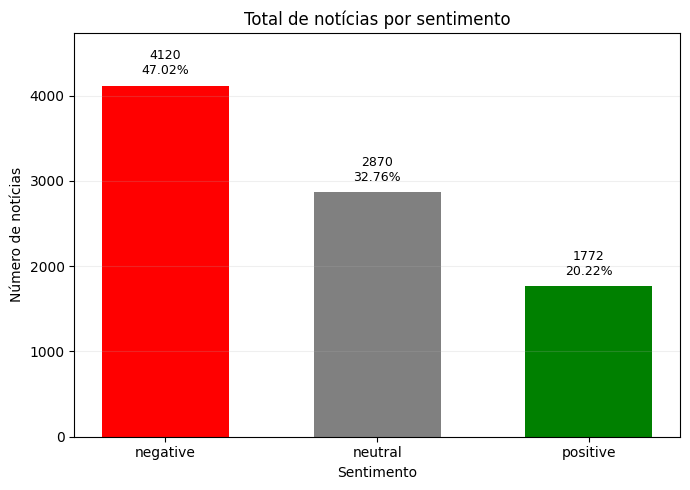

In [ ]:
# gráfico total de notícias por sentimento
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normaliza rótulos comuns para três categorias
def normalize_sentiment_label(x):
    if pd.isna(x):
        return "unknown"
    s = str(x).strip().lower()
    if s in ("positive", "pos", "positivo", "label_2", "label2", "label-2"):
        return "positive"
    if s in ("negative", "neg", "negativo", "label_0", "label0", "label-0"):
        return "negative"
    if s in ("neutral", "neutro", "neutra", "label_1", "label1", "label-1"):
        return "neutral"
    if s.startswith("label_"):
        try:
            idx = int(s.split("_")[-1])
            return {0: "negative", 1: "neutral", 2: "positive"}.get(idx, "unknown")
        except Exception:
            return "unknown"
    if "pos" in s:
        return "positive"
    if "neg" in s:
        return "negative"
    if "neu" in s or "neut" in s:
        return "neutral"
    return "unknown"

# Normaliza coluna de sentimento
df['sent_norm'] = df['sentimento'].apply(normalize_sentiment_label)

# Conta por sentimento
order = ["negative", "neutral", "positive", "unknown"]
counts = df['sent_norm'].value_counts().reindex(order, fill_value=0)

# Calcula porcentagens
total = counts.sum()
pct = (counts / total * 100).round(2)

# Filtra apenas categorias com valor > 0
counts_plot = counts[counts > 0]
pct_plot = pct[counts > 0]

# Cria figura
fig, ax = plt.subplots(figsize=(7,5))
bars = ax.bar(counts_plot.index, counts_plot.values, width=0.6, color=["red", "gray", "green", "lightgray"])

ax.set_xlabel("Sentimento")
ax.set_ylabel("Número de notícias")
ax.set_title("Total de notícias por sentimento")


ymax = counts_plot.max() * 1.15  # adiciona 15% de folga no topo
ax.set_ylim(0, ymax)

# Adiciona rótulos (quantidade + %)
for bar, c, p in zip(bars, counts_plot.values, pct_plot.values):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + ymax * 0.02,
        f"{int(c)}\n{p}%",
        ha='center',
        va='bottom',
        fontsize=9
    )

ax.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig('noticias_por_sentimento.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()



#2.2 Agregação de Sentimento

Os scores de sentimento por notícia são agregados por dia de pregão para formar indicadores diários (por exemplo: sent_mean, sent_median, sent_std, sent_count). No código esta agregação garante que cada dia de mercado receba uma única observação de sentimento — a variável `sent_mean` é então incorporada como feature suplementar nas janelas temporais do LSTM.


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(RESULT_CSV, parse_dates=["data"], dayfirst=True, infer_datetime_format=True)

# Tenta corrigir coluna de data, se necessário
if "data" not in df.columns or df["data"].isnull().all():
    for alt in ["published_at", "date", "timestamp"]:
        if alt in df.columns and not df[alt].isnull().all():
            df["data"] = pd.to_datetime(df[alt], errors="coerce")
            break

df = df.dropna(subset=["data"]).copy()
df["data"] = pd.to_datetime(df["data"]).dt.tz_localize(None)
df["date_only"] = df["data"].dt.date
df["date"] = pd.to_datetime(df["date_only"])

# Função para cálculo do score contínuo em [-1, 1]
def compute_sent_score(row, neutral_threshold=0.05):
    if {"pos_prob", "neg_prob"}.issubset(row.index):
        try:
            score = float(row["pos_prob"]) - float(row["neg_prob"])
        except Exception:
            score = np.nan
    else:
        label = str(row.get("sentimento", "")).lower()
        try:
            base_score = float(row.get("score", np.nan))
        except Exception:
            base_score = np.nan

        if label.startswith("pos") or label == "positive":
            score = base_score if not np.isnan(base_score) else 1.0
        elif label.startswith("neg") or label == "negative":
            score = -base_score if not np.isnan(base_score) else -1.0
        elif label.startswith("neu") or label == "neutral":
            # Neutros preservam leve viés dentro da faixa definida
            if np.isnan(base_score):
                score = 0.0
            else:
                score = np.clip(base_score, -neutral_threshold, neutral_threshold)
        else:
            score = 0.0

    # Garante faixa [-1, 1]
    if pd.notnull(score):
        score = np.clip(score, -1.0, 1.0)
    return score

df["sent_score"] = df.apply(compute_sent_score, axis=1)

# Agrega por dia
agg = df.groupby("date").sent_score.agg(
    sent_mean="mean",
    sent_median="median",
    sent_std="std",
    sent_count="count"
).sort_index()

# Reindexa para dias úteis (pregões)
start, end = agg.index.min(), agg.index.max()
business_days = pd.bdate_range(start=start, end=end, freq="C")

agg = agg.reindex(business_days)
agg["sent_count"] = agg["sent_count"].fillna(0).astype(int)
agg.loc[agg["sent_count"] == 0, ["sent_mean", "sent_median", "sent_std"]] = np.nan

agg.index.name = "date"
agg.to_csv("sentimento_diario.csv", index=True)

print(" Agregação concluída — arquivo salvo: sentimento_diario.csv")
print(agg.head(15))

/tmp/ipython-input-2190984735.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(RESULT_CSV, parse_dates=["data"], dayfirst=True, infer_datetime_format=True)


 Agregação concluída — arquivo salvo: sentimento_diario.csv
            sent_mean  sent_median  sent_std  sent_count
date                                                    
2025-05-01  -0.289405    -0.635723  0.609228          81
2025-05-02  -0.204281    -0.417328  0.587283          82
2025-05-05  -0.064030     0.050000  0.596815          76
2025-05-06  -0.038192     0.050000  0.642560          80
2025-05-07   0.016637     0.050000  0.613475          75
2025-05-08   0.181009     0.050000  0.541966          69
2025-05-09   0.035823     0.050000  0.600305          83
2025-05-12   0.085310     0.050000  0.583553          79
2025-05-13  -0.141580     0.050000  0.631284          74
2025-05-14  -0.044414     0.050000  0.566457          80
2025-05-15   0.049774     0.050000  0.626406          84
2025-05-16  -0.191746     0.050000  0.603210          75
2025-05-19  -0.191768     0.050000  0.541401          75
2025-05-20  -0.121041     0.050000  0.554362          73
2025-05-21  -0.200759     0.

#3.1 Processamento de Dados Financeiros e Integração

Após leitura, os dados financeiros e os indicadores de sentimento são unidos por índice de data. Aplica-se tratamento de faltantes e normalização (MinMaxScaler) fitado apenas no treino para evitar data leakage. Em seguida é feita a construção das sequências (lookback = 7 dias): cada X é uma matriz (7 timesteps × n_features) e y é o Close do dia seguinte (t+1). Esse merge/normalização/janelamento é o ponto crítico que converte dados brutos em entradas válidas para a LSTM.

In [ ]:
import os
import glob
import re
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib


TICKER_FILES_GLOB = "data_*_raw.csv"          # procura pelos 4 arquivos data_<TICKER>_raw.csv
SENT_FILE = "sentimento_diario.csv"           # arquivo de sentimento
OUT_UNIFIED = "unified_prices_sentiment.csv"  # saída unificada


def read_sentiment(sent_path=SENT_FILE):
    sent = pd.read_csv(sent_path, parse_dates=["date"])
    sent = sent.rename(columns=lambda c: c.strip())
    sent = sent.drop_duplicates(subset=["date"], keep="last")
    sent = sent.set_index("date").sort_index()
    # garante tipos corretos
    for col in ["sent_mean","sent_median","sent_std","sent_count"]:
        if col not in sent.columns:
            sent[col] = np.nan
    return sent

def ticker_from_filename(fname):
    base = os.path.basename(fname)
    m = re.match(r"data_(.+)_raw\.csv", base)
    if m:
        label = m.group(1)
        return label.replace("_", ".")
    return base

def read_price_file(path):
    df = pd.read_csv(path, parse_dates=["date"])
    # normaliza colnames
    df.columns = [c.strip().lower() for c in df.columns]
    # remove duplicatas de date (origem comum de erro)
    if "date" in df.columns:
        df = df.loc[~df["date"].duplicated(keep="last")].copy()
        df = df.sort_values("date")
        df = df.set_index("date")
    else:
        raise ValueError(f"Arquivo {path} sem coluna 'date'")
    # renomeia colunas que possam vir com maiúsculas (Open/Close)
    rename_map = {}
    for c in df.columns:
        if c.lower() in ["open","open ","open."]:
            rename_map[c] = "open"
        if c.lower() in ["high","low","close","volume"]:
            rename_map[c] = c.lower()
    df = df.rename(columns=rename_map)
    # calcula retorno linear (pct_change)
    if "close" not in df.columns:
        raise ValueError(f"Arquivo {path} não contém coluna 'close'")
    df["return_linear"] = df["close"].pct_change()
    return df

def build_unified(ticker_glob=TICKER_FILES_GLOB, sent_path=SENT_FILE, out_csv=OUT_UNIFIED):
    files = sorted(glob.glob(ticker_glob))
    if not files:
        raise FileNotFoundError(f"Nenhum arquivo encontrado com padrão {ticker_glob}")

    sent = read_sentiment(sent_path)

    # determina intervalo global de interesse: intersecção entre preços e sentimento
    # Para evitar perder toda a janela caso algum ticker seja mais curto, vamos usar o intervalo
    # comum entre cada ticker e o sentimento.
    unified_list = []

    for path in files:
        tk_label = ticker_from_filename(path)
        print(f"Processando {tk_label}  <- {path}")
        df = read_price_file(path)

        # interseção de datas entre esse ticker e sentimento
        start = max(df.index.min(), sent.index.min())
        end   = min(df.index.max(), sent.index.max())
        if pd.isna(start) or pd.isna(end) or start > end:
            print(f"  intervalo sem interseção entre preços ({df.index.min()}-{df.index.max()}) e sentimento ({sent.index.min()}-{sent.index.max()}). Pulando {tk_label}.")
            continue

        # criar business days (usando bdate_range padrão Mon-Fri).
        business_days = pd.bdate_range(start=start, end=end)

        # reindex para business days e remover dias sem preço (ex: feriado / mercado fechado)
        df_reindexed = df.reindex(business_days)
        df_reindexed = df_reindexed.dropna(subset=["close"]).copy()

        # junta sentimento (left join por índice de datas)
        merged = df_reindexed.join(sent, how="left")
        # sent_count = 0 quando NaN (dias sem notícia)
        merged["sent_count"] = merged["sent_count"].fillna(0).astype(int)
        mask_no_news = merged["sent_count"] == 0
        for c in ["sent_mean","sent_median","sent_std"]:
            if c in merged.columns:
                merged.loc[mask_no_news, c] = merged.loc[mask_no_news, c].where(pd.notnull(merged.loc[mask_no_news, c]), np.nan)
            else:
                merged[c] = np.nan

        merged = merged.reset_index().rename(columns={"index":"date"})
        merged["ticker"] = tk_label
        unified_list.append(merged)

        print(f"  ✔ {tk_label}: {len(merged)} dias com preço entre {merged['date'].min().date()} e {merged['date'].max().date()}")

    if not unified_list:
        raise RuntimeError("Nenhum ticker processado com sucesso. Verifique intervalos e arquivos.")

    # concatena todos os tickers
    unified = pd.concat(unified_list, ignore_index=True, sort=False)
    cols_order = ["date","ticker","open","high","low","close","volume","return_linear","sent_mean","sent_median","sent_std","sent_count"]
    cols_present = [c for c in cols_order if c in unified.columns] + [c for c in unified.columns if c not in cols_order]
    unified = unified[cols_present]

    unified.to_csv(out_csv, index=False)
    print(f"\nUnificado salvo em: {out_csv} ({len(unified)} linhas, {unified['ticker'].nunique()} tickers)")

    return unified

if __name__ == "__main__":
    unified = build_unified()
    feature_cols = ["return_linear","sent_mean","sent_median","sent_std","volume"]


Processando BOVA11.SA  <- data_BOVA11_SA_raw.csv
  ✔ BOVA11.SA: 85 dias com preço entre 2025-05-02 e 2025-08-29
Processando EMBR3.SA  <- data_EMBR3_SA_raw.csv
  ✔ EMBR3.SA: 85 dias com preço entre 2025-05-02 e 2025-08-29
Processando PETR4.SA  <- data_PETR4_SA_raw.csv
  ✔ PETR4.SA: 85 dias com preço entre 2025-05-02 e 2025-08-29
Processando VALE3.SA  <- data_VALE3_SA_raw.csv
  ✔ VALE3.SA: 85 dias com preço entre 2025-05-02 e 2025-08-29

Unificado salvo em: unified_prices_sentiment.csv (340 linhas, 4 tickers)
